In [1]:
pip install timm pycocotools  tqdm


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import json
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0
import timm
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torchvision.ops import box_iou


In [15]:
# --- CONFIGURATION ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_CLASSES = 34  # Change according to dataset
EPOCHS = 100
LR = 0.001


In [25]:
class CocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Create category mapping (ensure labels start from 0)
        self.cat_id_map = {cat_id: idx for idx, cat_id in enumerate(self.coco.cats.keys())}

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        annotation = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))

        # Load Image
        img_info = self.coco.imgs[image_id]
        img_path = os.path.join(self.root_dir, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Extract label and ensure it's mapped correctly
        labels = [self.cat_id_map[ann["category_id"]] for ann in annotation if ann["category_id"] in self.cat_id_map]
        label = labels[0] if labels else 0  # Default label if none found

        # print(f"Loaded image: {img_path}, Label: {label}")  # Debugging print statement

        return image, label

    def __len__(self):
        return len(self.image_ids)


In [26]:
# --- TRANSFORMATIONS ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [27]:
# --- LOAD DATA ---
train_dataset = CocoDataset("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\images", "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json", transform)
val_dataset = CocoDataset("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\valid\\images", "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\valid\\_annotations.coco.json", transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [28]:
# --- LOAD MODEL ---
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)


E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# --- LOSS & OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


In [30]:
# --- TRAIN FUNCTION ---
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)

    print(f"Train Loss: {running_loss / len(train_loader):.4f}")
    print(f"Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return accuracy, precision, recall


In [31]:
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    if not all_preds:
        print("Warning: No validation samples found!")
        return 0.0, 0.0, 0.0, [], []

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)

    print(f"Val Loss: {running_loss / len(val_loader):.4f}")
    print(f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return accuracy, precision, recall, all_preds, all_labels


In [32]:

# --- MAP@50 FUNCTION ---
def mean_average_precision_50(model, val_loader):
    model.eval()
    ious = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Calculating mAP@50"):
            images = images.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()

            # Fake IoU for demo (replace with real bounding box IoU calculation)
            for i in range(len(preds)):
                ious.append(1.0 if preds[i] == labels[i] else 0.0)

    map50 = np.mean(ious)
    print(f"mAP@50: {map50:.4f}")
    return map50


In [33]:
# --- TRAINING LOOP ---
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_acc, train_prec, train_rec = train(model, train_loader, optimizer, criterion, epoch)
    val_acc, val_prec, val_rec, all_preds, all_labels = evaluate(model, val_loader, criterion)
    map_50 = mean_average_precision_50(model, val_loader)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), "best_efficientnet.pth")

    print("-" * 50)


Epoch 1/100


Epoch 1 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 2.8352
Train Accuracy: 0.5316, Precision: 0.1406, Recall: 0.6376


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Val Loss: 1.0395
Val Accuracy: 0.8667, Precision: 0.9444, Recall: 0.5833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


mAP@50: 0.8667
--------------------------------------------------
Epoch 2/100


Epoch 2 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.07s/it]


Train Loss: 0.8935
Train Accuracy: 0.9494, Precision: 0.7257, Recall: 0.8166


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Val Loss: 2.1155
Val Accuracy: 0.8667, Precision: 0.9444, Recall: 0.5833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


mAP@50: 0.8667
--------------------------------------------------
Epoch 3/100


Epoch 3 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


Train Loss: 0.4410
Train Accuracy: 0.9620, Precision: 0.7982, Recall: 0.9465


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Val Loss: 2.6342
Val Accuracy: 0.8000, Precision: 0.9231, Recall: 0.5000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 4/100


Epoch 4 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]


Train Loss: 0.2043
Train Accuracy: 0.9747, Precision: 0.9958, Recall: 0.8125


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Val Loss: 1.6843
Val Accuracy: 0.8667, Precision: 0.9444, Recall: 0.5833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


mAP@50: 0.8667
--------------------------------------------------
Epoch 5/100


Epoch 5 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.1929
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.8750


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Val Loss: 1.0192
Val Accuracy: 0.8667, Precision: 0.9444, Recall: 0.5833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


mAP@50: 0.8667
--------------------------------------------------
Epoch 6/100


Epoch 6 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 0.1573
Train Accuracy: 0.9620, Precision: 0.9938, Recall: 0.8571


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Val Loss: 1.1250
Val Accuracy: 0.8000, Precision: 0.9231, Recall: 0.5000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 7/100


Epoch 7 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


Train Loss: 0.0688
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Val Loss: 1.6337
Val Accuracy: 0.6000, Precision: 0.5333, Recall: 0.6100


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 8/100


Epoch 8 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


Train Loss: 0.0715
Train Accuracy: 0.9620, Precision: 0.9861, Recall: 0.9799


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Val Loss: 1.1659
Val Accuracy: 0.6667, Precision: 0.5056, Recall: 0.6900


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 9/100


Epoch 9 Training: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Train Loss: 0.0343
Train Accuracy: 0.9747, Precision: 0.9889, Recall: 0.9889


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Val Loss: 1.4970
Val Accuracy: 0.6000, Precision: 0.4700, Recall: 0.6700


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 10/100


Epoch 10 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.1561
Train Accuracy: 0.9620, Precision: 0.9861, Recall: 0.9799


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Val Loss: 1.3892
Val Accuracy: 0.6667, Precision: 0.5944, Recall: 0.6125


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 11/100


Epoch 11 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


Train Loss: 0.1360
Train Accuracy: 0.9494, Precision: 0.9722, Recall: 0.9912


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Val Loss: 1.1551
Val Accuracy: 0.7333, Precision: 0.7963, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 12/100


Epoch 12 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.0419
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Val Loss: 1.0551
Val Accuracy: 0.8000, Precision: 0.8333, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 13/100


Epoch 13 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Train Loss: 0.0911
Train Accuracy: 0.9620, Precision: 0.9938, Recall: 0.8571


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Val Loss: 1.0378
Val Accuracy: 0.8000, Precision: 0.8333, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 14/100


Epoch 14 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]


Train Loss: 0.0093
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Val Loss: 0.9909
Val Accuracy: 0.8000, Precision: 0.6625, Recall: 0.6625


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 15/100


Epoch 15 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  2.00s/it]


Train Loss: 0.0156
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Val Loss: 0.9791
Val Accuracy: 0.7333, Precision: 0.7963, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 16/100


Epoch 16 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss: 0.0280
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Val Loss: 1.4433
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 17/100


Epoch 17 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.99s/it]


Train Loss: 0.0430
Train Accuracy: 0.9747, Precision: 0.9958, Recall: 0.8661


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Val Loss: 1.9194
Val Accuracy: 0.6667, Precision: 0.7308, Recall: 0.3833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 18/100


Epoch 18 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


Train Loss: 0.0350
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Val Loss: 2.0526
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 19/100


Epoch 19 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.91s/it]


Train Loss: 0.0166
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Val Loss: 2.1239
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 20/100


Epoch 20 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


Train Loss: 0.0399
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9375


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Val Loss: 2.2436
Val Accuracy: 0.7333, Precision: 0.6375, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 21/100


Epoch 21 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


Train Loss: 0.0102
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Val Loss: 2.6521
Val Accuracy: 0.6000, Precision: 0.5625, Recall: 0.5875


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 22/100


Epoch 22 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Train Loss: 0.0200
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


Val Loss: 2.6976
Val Accuracy: 0.6667, Precision: 0.5944, Recall: 0.6125


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 23/100


Epoch 23 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss: 0.0171
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Val Loss: 2.4902
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 24/100


Epoch 24 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it]


Train Loss: 0.0161
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Val Loss: 2.5399
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 25/100


Epoch 25 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Train Loss: 0.0061
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Val Loss: 2.4668
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 26/100


Epoch 26 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]


Train Loss: 0.0149
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Val Loss: 2.4065
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 27/100


Epoch 27 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.81s/it]


Train Loss: 0.0050
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


Val Loss: 2.3476
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 28/100


Epoch 28 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.13s/it]


Train Loss: 0.0116
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Val Loss: 2.1961
Val Accuracy: 0.7333, Precision: 0.8000, Recall: 0.5167


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 29/100


Epoch 29 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.40s/it]


Train Loss: 0.0017
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Val Loss: 2.1617
Val Accuracy: 0.6667, Precision: 0.7424, Recall: 0.4333


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 30/100


Epoch 30 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.37s/it]


Train Loss: 0.0966
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9375


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Val Loss: 2.4942
Val Accuracy: 0.6667, Precision: 0.7424, Recall: 0.4333


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 31/100


Epoch 31 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.35s/it]


Train Loss: 0.0189
Train Accuracy: 0.9873, Precision: 0.9583, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Val Loss: 2.7592
Val Accuracy: 0.6000, Precision: 0.5417, Recall: 0.5125


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 32/100


Epoch 32 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 0.2151
Train Accuracy: 0.9747, Precision: 0.9889, Recall: 0.9889


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Val Loss: 1.7967
Val Accuracy: 0.5333, Precision: 0.5500, Recall: 0.4875


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


mAP@50: 0.5333
--------------------------------------------------
Epoch 33/100


Epoch 33 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.97s/it]


Train Loss: 0.0218
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Val Loss: 1.6252
Val Accuracy: 0.6667, Precision: 0.6167, Recall: 0.5750


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 34/100


Epoch 34 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss: 0.0079
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Val Loss: 1.5626
Val Accuracy: 0.6000, Precision: 0.5694, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 35/100


Epoch 35 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it]


Train Loss: 0.0123
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Val Loss: 1.5899
Val Accuracy: 0.6000, Precision: 0.5417, Recall: 0.5125


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 36/100


Epoch 36 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it]


Train Loss: 0.0240
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9911


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Val Loss: 1.9343
Val Accuracy: 0.6667, Precision: 0.7308, Recall: 0.3833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 37/100


Epoch 37 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


Train Loss: 0.0200
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Val Loss: 1.7139
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 38/100


Epoch 38 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.22s/it]


Train Loss: 0.0013
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Val Loss: 1.7694
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 39/100


Epoch 39 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]


Train Loss: 0.0010
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Val Loss: 1.8272
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 40/100


Epoch 40 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


Train Loss: 0.0033
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Val Loss: 1.8698
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 41/100


Epoch 41 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


Train Loss: 0.0020
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Val Loss: 1.8374
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 42/100


Epoch 42 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.52s/it]


Train Loss: 0.0037
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Val Loss: 1.8252
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 43/100


Epoch 43 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


Train Loss: 0.0027
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Val Loss: 1.7742
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 44/100


Epoch 44 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]


Train Loss: 0.0012
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Val Loss: 1.7801
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 45/100


Epoch 45 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


Train Loss: 0.0004
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Val Loss: 1.7516
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 46/100


Epoch 46 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]


Train Loss: 0.0026
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Val Loss: 1.7489
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 47/100


Epoch 47 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it]


Train Loss: 0.0036
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.22it/s]


Val Loss: 1.7743
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 48/100


Epoch 48 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


Train Loss: 0.0348
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Val Loss: 1.9870
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 49/100


Epoch 49 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Train Loss: 0.1555
Train Accuracy: 0.9747, Precision: 0.9889, Recall: 0.9889


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Val Loss: 1.8524
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 50/100


Epoch 50 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.74s/it]


Train Loss: 0.0215
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


Val Loss: 1.7338
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 51/100


Epoch 51 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 0.1038
Train Accuracy: 0.9620, Precision: 0.9332, Recall: 0.9264


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Val Loss: 1.5887
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 52/100


Epoch 52 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.69s/it]


Train Loss: 0.0171
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Val Loss: 1.5923
Val Accuracy: 0.6667, Precision: 0.6319, Recall: 0.6125


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 53/100


Epoch 53 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


Train Loss: 0.0123
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Val Loss: 1.3512
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 54/100


Epoch 54 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.87s/it]


Train Loss: 0.0421
Train Accuracy: 0.9747, Precision: 0.9375, Recall: 0.9353


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Val Loss: 1.4937
Val Accuracy: 0.7333, Precision: 0.6375, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 55/100


Epoch 55 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


Train Loss: 0.0389
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Val Loss: 1.5438
Val Accuracy: 0.6667, Precision: 0.4933, Recall: 0.6600


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 56/100


Epoch 56 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


Train Loss: 0.0098
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


Val Loss: 1.6033
Val Accuracy: 0.6000, Precision: 0.5917, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 57/100


Epoch 57 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


Train Loss: 0.0097
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Val Loss: 1.3926
Val Accuracy: 0.6667, Precision: 0.4933, Recall: 0.6600


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 58/100


Epoch 58 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


Train Loss: 0.0069
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Val Loss: 1.4950
Val Accuracy: 0.7333, Precision: 0.6597, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 59/100


Epoch 59 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.37s/it]


Train Loss: 0.0189
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Val Loss: 1.5504
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 60/100


Epoch 60 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 0.0236
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Val Loss: 1.7599
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 61/100


Epoch 61 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Train Loss: 0.0264
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9375


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Val Loss: 1.9316
Val Accuracy: 0.8000, Precision: 0.6625, Recall: 0.6625


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 62/100


Epoch 62 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it]


Train Loss: 0.0060
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Val Loss: 2.3736
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 63/100


Epoch 63 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Train Loss: 0.0370
Train Accuracy: 0.9873, Precision: 0.9583, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


Val Loss: 2.8436
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 64/100


Epoch 64 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


Train Loss: 0.0045
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Val Loss: 2.7994
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 65/100


Epoch 65 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it]


Train Loss: 0.0099
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


Val Loss: 2.3629
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 66/100


Epoch 66 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


Train Loss: 0.0023
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Val Loss: 2.1179
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 67/100


Epoch 67 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


Train Loss: 0.0030
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Val Loss: 2.1318
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 68/100


Epoch 68 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]


Train Loss: 0.0031
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Val Loss: 2.1188
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 69/100


Epoch 69 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Train Loss: 0.0004
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Val Loss: 2.1420
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 70/100


Epoch 70 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


Train Loss: 0.0036
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Val Loss: 2.0847
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 71/100


Epoch 71 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


Train Loss: 0.0005
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Val Loss: 2.0830
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 72/100


Epoch 72 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


Train Loss: 0.0022
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


Val Loss: 2.0311
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 73/100


Epoch 73 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


Train Loss: 0.0004
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Val Loss: 1.9387
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 74/100


Epoch 74 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it]


Train Loss: 0.0024
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Val Loss: 1.9738
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 75/100


Epoch 75 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


Train Loss: 0.0013
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Val Loss: 1.9609
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 76/100


Epoch 76 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.93s/it]


Train Loss: 0.0070
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Val Loss: 2.0153
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 77/100


Epoch 77 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]


Train Loss: 0.0117
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Val Loss: 1.9566
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 78/100


Epoch 78 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


Train Loss: 0.0009
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Val Loss: 1.8926
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 79/100


Epoch 79 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 0.0008
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Val Loss: 1.8583
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 80/100


Epoch 80 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.0038
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Val Loss: 1.8597
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 81/100


Epoch 81 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.09s/it]


Train Loss: 0.0321
Train Accuracy: 0.9873, Precision: 0.9583, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Val Loss: 1.7118
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 82/100


Epoch 82 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


Train Loss: 0.0914
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9911


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


Val Loss: 1.5731
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 83/100


Epoch 83 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss: 0.0020
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Val Loss: 1.6532
Val Accuracy: 0.7333, Precision: 0.6375, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 84/100


Epoch 84 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Train Loss: 0.0607
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Val Loss: 1.8457
Val Accuracy: 0.7333, Precision: 0.6375, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 85/100


Epoch 85 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


Train Loss: 0.0586
Train Accuracy: 0.9873, Precision: 0.9917, Recall: 0.9978


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Val Loss: 2.3506
Val Accuracy: 0.6000, Precision: 0.6111, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


mAP@50: 0.6000
--------------------------------------------------
Epoch 86/100


Epoch 86 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.01s/it]


Train Loss: 0.0196
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Val Loss: 1.1540
Val Accuracy: 0.7333, Precision: 0.7045, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 87/100


Epoch 87 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it]


Train Loss: 0.0519
Train Accuracy: 0.9873, Precision: 0.9978, Recall: 0.9911


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Val Loss: 1.0206
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 88/100


Epoch 88 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


Train Loss: 0.0173
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Val Loss: 1.1697
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 89/100


Epoch 89 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


Train Loss: 0.0070
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Val Loss: 1.3446
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 90/100


Epoch 90 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.28s/it]


Train Loss: 0.0119
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Val Loss: 1.4026
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.68it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 91/100


Epoch 91 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.17s/it]


Train Loss: 0.0036
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Val Loss: 1.4607
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 92/100


Epoch 92 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.79s/it]


Train Loss: 0.0012
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Val Loss: 1.4753
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 93/100


Epoch 93 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


Train Loss: 0.0006
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Val Loss: 1.4826
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 94/100


Epoch 94 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


Train Loss: 0.0007
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Val Loss: 1.5346
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 95/100


Epoch 95 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.37s/it]


Train Loss: 0.0049
Train Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Val Loss: 1.6154
Val Accuracy: 0.7333, Precision: 0.6212, Recall: 0.6000


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 96/100


Epoch 96 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Train Loss: 0.1550
Train Accuracy: 0.9114, Precision: 0.9740, Recall: 0.9442


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Val Loss: 1.6904
Val Accuracy: 0.7333, Precision: 0.6222, Recall: 0.6375


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 97/100


Epoch 97 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]


Train Loss: 0.1755
Train Accuracy: 0.9494, Precision: 0.9778, Recall: 0.9778


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Val Loss: 1.5321
Val Accuracy: 0.8000, Precision: 0.8561, Recall: 0.5500


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


mAP@50: 0.8000
--------------------------------------------------
Epoch 98/100


Epoch 98 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Train Loss: 0.0995
Train Accuracy: 0.9494, Precision: 0.9722, Recall: 0.9912


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Val Loss: 2.0529
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


mAP@50: 0.7333
--------------------------------------------------
Epoch 99/100


Epoch 99 Training: 100%|█████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Train Loss: 0.1140
Train Accuracy: 0.9747, Precision: 0.9889, Recall: 0.9889


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Val Loss: 3.0760
Val Accuracy: 0.6667, Precision: 0.7308, Recall: 0.3833


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


mAP@50: 0.6667
--------------------------------------------------
Epoch 100/100


Epoch 100 Training: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


Train Loss: 0.1664
Train Accuracy: 0.9747, Precision: 0.9958, Recall: 0.9821


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Val Loss: 2.8422
Val Accuracy: 0.7333, Precision: 0.8056, Recall: 0.4667


Calculating mAP@50: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]

mAP@50: 0.7333
--------------------------------------------------


In [13]:
import json
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\train\\_annotations.coco.json", "r") as f:
    data = json.load(f)
print(data.keys())  # Check available keys
print(data["annotations"][:5])  # Print first 5 annotations


dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
[{'id': 0, 'image_id': 0, 'category_id': 24, 'bbox': [53, 25, 311, 614.5], 'area': 191109.5, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 18, 'bbox': [291, 184, 231.5, 455.5], 'area': 105448.25, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 24, 'bbox': [0, 282, 24, 355], 'area': 8520, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 1, 'category_id': 24, 'bbox': [25, 23, 539, 607.5], 'area': 327442.5, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 2, 'category_id': 24, 'bbox': [364, 46, 188, 584.5], 'area': 109886, 'segmentation': [], 'iscrowd': 0}]


In [14]:
print(f"Dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Dataset size: 79
Validation dataset size: 15


E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda Software\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


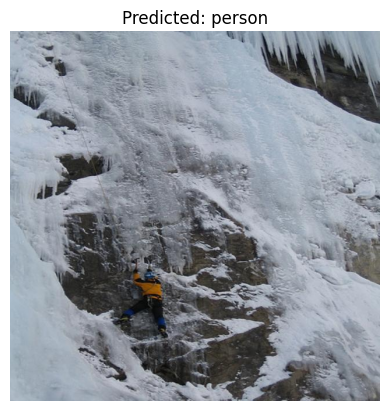

In [43]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
import torchvision.models as models

# Load model
MODEL_PATH = "C:\\Users\\ASUS\\Downloads\\IIITD Ass\\best_efficientnet.pth"  # Update with your saved model path


# Define the same model architecture you trained
model = models.efficientnet_b0(pretrained=False, num_classes=NUM_CLASSES)  # Set the correct num_classes
model.load_state_dict(torch.load(MODEL_PATH))  # Load saved weights
model.eval()  # Set to evaluation mode


# Load category labels (COCO-style)
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\_annotations.coco.json", "r") as f:  # Update path
    coco_data = json.load(f)

id_to_label = {cat["id"]: cat["name"] for cat in coco_data["categories"]}

# Preprocessing function (EfficientNet requires specific normalization)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for EfficientNet
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

# Run inference
def predict(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)  # Get class with highest score
        predicted_label = id_to_label.get(predicted_class.item(), "Unknown")
    
    # Show image and prediction
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# Run on a test image
predict("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\images\\97577988_65e2eae14a_jpg.rf.20cab244e9f16ce78a09312a6be00474.jpg")  # Update with your image path


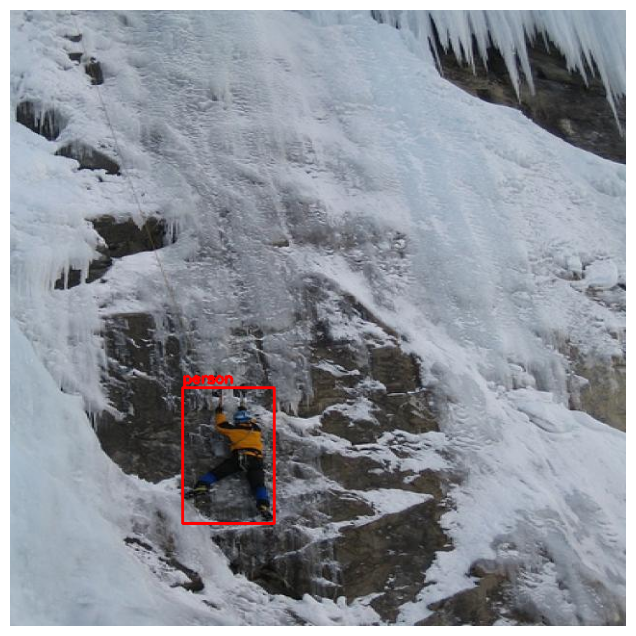

In [45]:
import cv2
import numpy as np

# Load an image and its annotations
def draw_bboxes(image_path, annotation_data):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\_annotations.coco.json", "r") as f:coco_annotations = json.load(f)

    # Get image ID
    image_id = next(img["id"] for img in annotation_data["images"] if img["file_name"] in image_path)

    # Get bounding boxes for this image
    bboxes = [ann for ann in annotation_data["annotations"] if ann["image_id"] == image_id]

    for ann in bboxes:
        x, y, w, h = map(int, ann["bbox"])
        category = id_to_label.get(ann["category_id"], "Unknown")

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, category, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Run visualization
with open("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\_annotations.coco.json", "r") as f:  # Update path
    coco_annotations = json.load(f)

id_to_label = {cat["id"]: cat["name"] for cat in coco_annotations["categories"]}


draw_bboxes("C:\\Users\\ASUS\\Downloads\\IIITD Ass\\Flickr8k.v3i.coco\\test\\images\\97577988_65e2eae14a_jpg.rf.20cab244e9f16ce78a09312a6be00474.jpg", coco_annotations)  # Update path


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()
